In [185]:
import sys
sys.path.append('/Users/theohanon/Desktop/Master II/TFE/Experiences/SAMPTA')

import numpy as np
import pyshtools
from inr import SphericalSiren, SIREN, train
from utils import plot_SHT_coeffs, plot_losses
from chebychev import Chebyshev
from sampling import sample_s2
from plotting import plot_sphere
import matplotlib.pyplot as plt


import torch_harmonics as th
import torch
from sklearn.preprocessing import StandardScaler
import imageio.v3 as iio


In [45]:
L = 200
phi, theta, (nlon, nlat) = sample_s2(L, sampling = "gl", torch_tensor = True)

In [32]:
coefficients = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 200)

In [33]:
world_map = coefficients.expand(lon = phi.numpy().flatten(), colat = theta.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat, nlon)

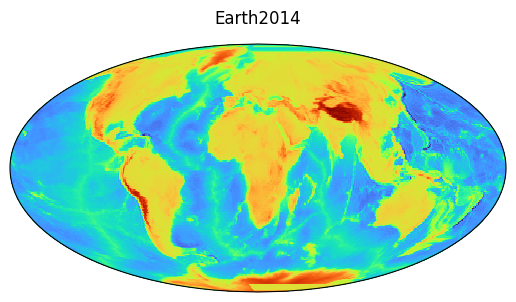

In [34]:
plot_sphere(world_map, molweide=True, cmap = "turbo", title = "Earth2014")
plt.show()

In [35]:
scaler = StandardScaler()
world_map_scaled = scaler.fit_transform(world_map)

X = torch.stack([theta.flatten(), phi.flatten()], dim=-1).float()
y = torch.tensor(world_map_scaled.copy()).flatten().unsqueeze(1).float()

In [174]:
sh_siren = SphericalSiren(
    L0 = 12, 
    Q = 3,
    hidden_features = 100, 
    activation = Chebyshev(order = 3, alpha = 1.0), 
    first_activation=Chebyshev(order = 10, alpha = 1.0))

siren = SIREN(

    in_features=2, 
    hidden_features=100,
    n_hidden_layers=5,
    out_features=1,
    first_omega_0=5.0,
    hidden_omega=5.0,
    
)

# Compute number of parameters
n_params_siren = sum(p.numel() for p in siren.parameters())
print(f"Number of parameters: {n_params_siren}")
n_params_sh_siren = sum(p.numel() for p in sh_siren.parameters())
print(f"Number of parameters: {n_params_sh_siren}")

Number of parameters: 50900
Number of parameters: 37301


In [175]:
print("Expansion = ", 
      15 * 10 * 3 )

Expansion =  450


In [184]:
loss_train_siren = train(
    x = X,
    y = y,
    model = siren,
    epochs = 1000,
    batch_size = 2048,
    optimizer = torch.optim.AdamW(siren.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(),
)

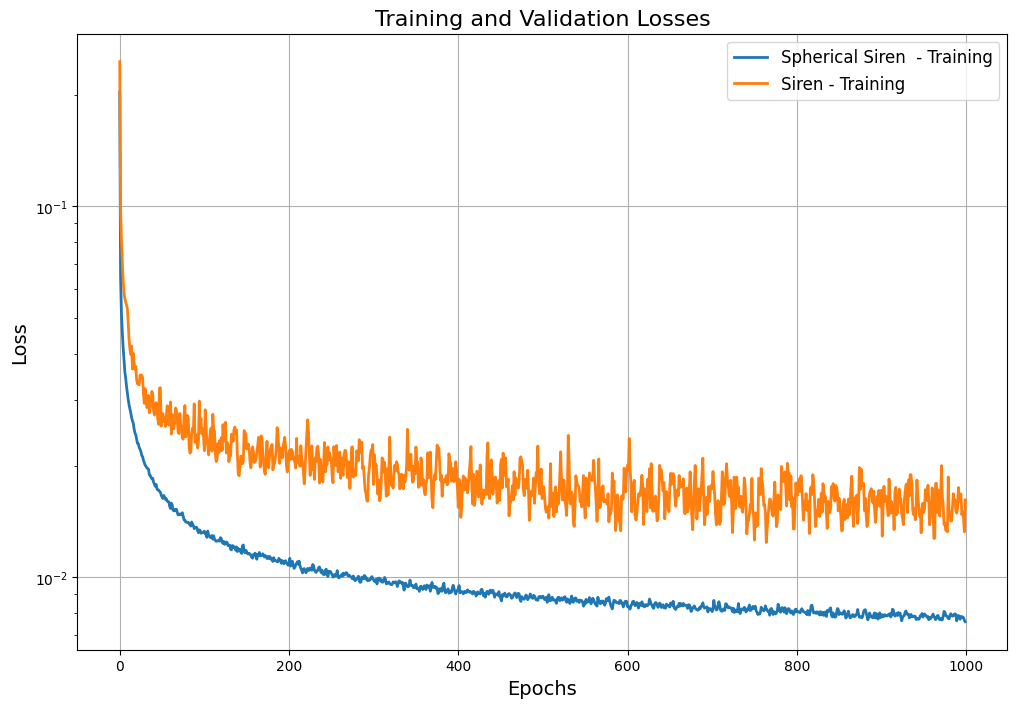

In [187]:
plot_losses({
   "Spherical Siren ":  (loss_train, None),
   "Siren" : (loss_train_siren, None)
   })

In [188]:
pred_sh = sh_siren(X).detach().numpy().reshape(nlat, nlon)
pred_sh = scaler.inverse_transform(pred_sh)


pred = siren(X).detach().numpy().reshape(nlat, nlon)
pred = scaler.inverse_transform(pred)

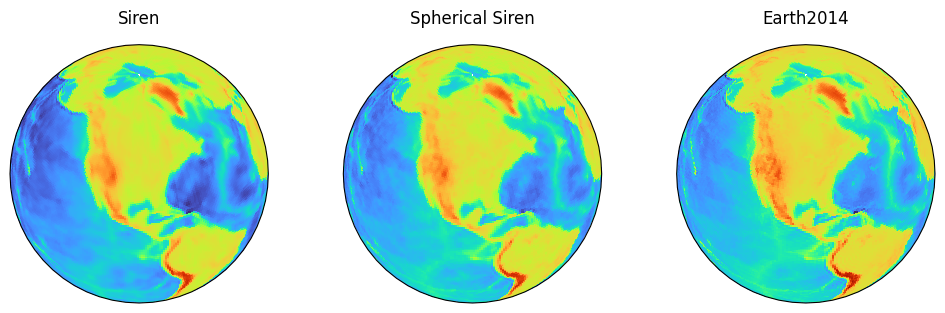

In [189]:
fig = plt.figure(figsize=(10, 5))
subfigs = fig.subfigures(1, 3)

plot_sphere(pred, cmap = "turbo", title = "Siren", central_latitude=40, central_longitude=-90, fig=subfigs[0])
plot_sphere(pred_sh, cmap = "turbo", title = "Spherical Siren", central_latitude=40, central_longitude=-90, fig=subfigs[1])
plot_sphere(world_map, cmap = "turbo", title = "Earth2014", central_latitude=40, central_longitude=-90, fig=subfigs[2])

plt.show()

In [182]:
sht = th.RealSHT(nlat = nlat, nlon = nlon, lmax = L, grid = "legendre-gauss")

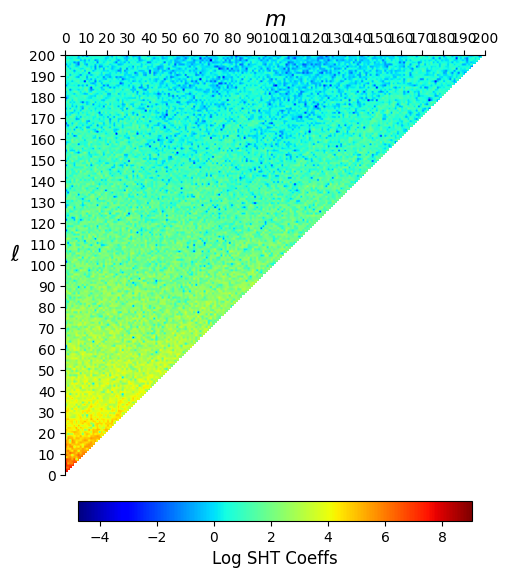

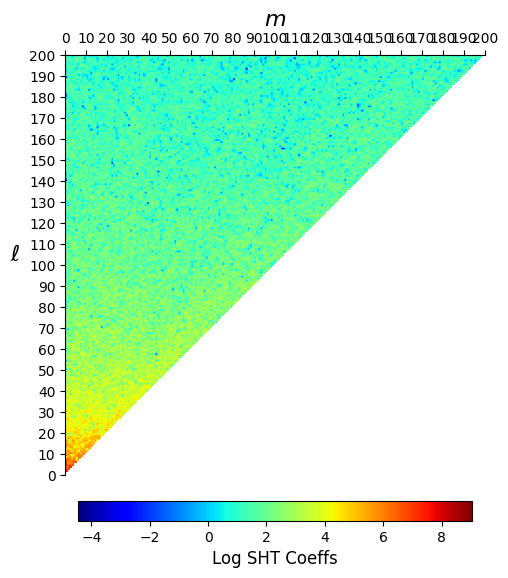

In [183]:
coeffs = sht(torch.tensor(pred_sh))
plot_SHT_coeffs(coeffs, cmap ="jet")

coeffs_gt = sht(torch.tensor(world_map))
plot_SHT_coeffs(coeffs_gt, cmap ="jet")